In [388]:
# used for handle data
import pandas as pd

# used to handle geo data
from shapely.ops import transform, Point
from geopandas.tools import reverse_geocode
import geopandas as gpd

# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# tells matplotlib to embed plots within the notebook
%matplotlib inline

import sys
sys.path.append('./')

# import hvplot.pandas

from matplotlib import pyplot as plt

read AIRBNB data

In [389]:
data = pd.read_csv('BigML_Dataset_5dd97775fb7bdd184c00024f.csv')
data.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,calendar_last_scraped.day-of-month,calendar_last_scraped.day-of-week,first_review.year,first_review.month,first_review.day-of-month,first_review.day-of-week,last_review.year,last_review.month,last_review.day-of-month,last_review.day-of-week
0,9784567,https://www.airbnb.com/rooms/9784567,20160704013910,2016-07-04,nice Room in Amsterdam,nice Room 20 Min.to Amst.center 10 minutes wal...,NaN,nice Room 20 Min.to Amst.center 10 minutes wal...,none,nice Park metro in front bus in front,...,4,1,2016.0,1.0,2.0,6.0,2016.0,6.0,27.0,1.0
1,13163805,https://www.airbnb.com/rooms/13163805,20160704013910,2016-07-04,Best cost benefit room near a metro station,We (me and my wife) are constantly improving o...,NaN,We (me and my wife) are constantly improving o...,none,NaN,...,4,1,2016.0,6.0,13.0,1.0,2016.0,6.0,27.0,1.0
2,3719167,https://www.airbnb.com/rooms/3719167,20160704013910,2016-07-04,Nice room in A´dam SE near nature & heart centre,I offer a beautiful 19 sqm room in a house on ...,"The location is close to the shops, public tra...",I offer a beautiful 19 sqm room in a house on ...,none,A lot of different internationalities and cult...,...,4,1,2014.0,8.0,17.0,7.0,2016.0,1.0,2.0,6.0
3,13188367,https://www.airbnb.com/rooms/13188367,20160704013910,2016-07-04,Private room 15min metro ride from city center,The apartment is located a 15min ride from the...,NaN,The apartment is located a 15min ride from the...,none,NaN,...,4,1,2016.0,5.0,29.0,7.0,2016.0,5.0,31.0,2.0
4,4831606,https://www.airbnb.com/rooms/4831606,20160704013910,2016-07-04,Room in Amsterdam in a new house!! Free Bicycle,In Amsterdam Zuidoost (20 minutes to central s...,Smart tv,In Amsterdam Zuidoost (20 minutes to central s...,none,NaN,...,4,1,2015.0,1.0,2.0,5.0,2016.0,3.0,22.0,2.0


removing rows and columns that contains significant amount of nans

In [390]:
cleaned_data = data.dropna(axis='columns',thresh=0.8*data.shape[0])
cleaned_data = cleaned_data.dropna(axis='index',how='any')


In [391]:
cleaned_numeric_data = cleaned_data.select_dtypes(exclude=['object'])

In [392]:
# extracting the prices and removing them from the dt
# y = cleaned_numeric_data['price']
# cleaned_numeric_data = cleaned_numeric_data.drop(columns='price')

In [393]:
cleaned_numeric_data.plot

In [394]:
# normalize values
def featureNormalize(X):
    """
    Normalizes the features in X. returns a normalized version of X where
    the mean value of each feature is 0 and the standard deviation
    is 1. This is often a good preprocessing step to do when working with
    learning algorithms.

    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n).

    Returns
    -------
    X_norm : array_like
        The normalized dataset of shape (m x n).

    """
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    n = (X.shape[0])
    mu = np.average(X, 0)
    mat1 = np.dot(mu.T[:, None], np.ones([1, n])).T
    X_norm = X_norm - mat1

    sigma = np.std(X, 0)
    mat2 = np.dot(sigma.T[:, None], np.ones([1, n])).T
    X_norm = X_norm / mat2

    return X_norm, mu, sigma

In [395]:
values = cleaned_numeric_data.values
norm_values, mean, sigma = featureNormalize(values)

normalized_data = pd.DataFrame(norm_values, index=cleaned_numeric_data.index, columns=cleaned_numeric_data.columns)
normalized_data = normalized_data.dropna(axis='columns')
normalized_data.head()

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


,id,host_id,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,...,host_since.day-of-month,host_since.day-of-week,first_review.year,first_review.month,first_review.day-of-month,first_review.day-of-week,last_review.year,last_review.month,last_review.day-of-month,last_review.day-of-week
0,0.761484,0.381627,0.445549,0.643142,-0.14818,-0.14818,-2.817112,2.704464,-0.673103,-0.353720,...,-1.177259,0.108664,0.982438,-1.606073,-1.435241,0.987685,0.262603,0.263241,1.036298,-1.242037
1,1.641562,0.818840,0.445549,0.643142,-0.24134,-0.24134,-3.327567,2.717651,-0.673103,-0.353720,...,-0.608393,-0.383008,0.982438,0.030238,-0.240153,-1.147978,0.262603,0.263241,1.036298,-1.242037
2,-0.818169,-0.059765,-1.512262,-0.101024,-0.24134,-0.24134,-3.256594,2.972943,-0.673103,-0.353720,...,1.325752,1.583682,-0.855699,0.684762,0.194425,1.414818,0.262603,-3.083600,-1.744954,0.824347
4,-0.528449,0.223694,0.445549,-1.239161,-0.24134,-0.24134,-2.559634,2.390976,-1.346362,-0.353720,...,1.667072,1.583682,0.063369,-1.606073,-1.435241,0.560553,0.262603,-1.744863,0.480048,-0.828761
6,-1.632611,-0.933590,-0.337575,0.643142,-0.24134,-0.24134,-2.578703,2.862120,1.346675,1.095993,...,-0.835940,0.600337,-2.693836,1.012025,-1.109308,-0.293712,0.262603,0.263241,0.925048,1.237624


visualize the data

<Figure size 432x288 with 0 Axes>

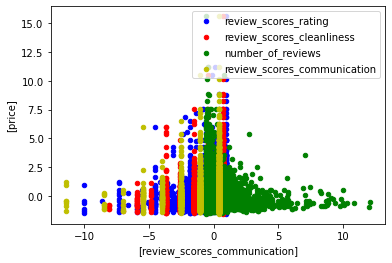

In [396]:
plt.figure()

ax = normalized_data.plot(x=['review_scores_rating'], y=['price'], color='b', label= 'review_scores_rating', kind='scatter')
normalized_data.plot(x=['review_scores_cleanliness'], y=['price'], color='r', label= 'review_scores_cleanliness', kind='scatter', ax=ax)
normalized_data.plot(x=['number_of_reviews'], y=['price'], color='g', label= 'number_of_reviews', kind='scatter', ax=ax)
normalized_data.plot(x=['review_scores_communication'], y=['price'], color='y', label= 'review_scores_communication', kind='scatter', ax=ax)
plt.show()

compute cost and gradient decent functions

In [397]:
def computeCost(X, y, theta):
    """
    Compute cost for linear regression. Computes the cost of using theta as the
    parameter for linear regression to fit the data points in X and y.

    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n+1), where m is the number of examples,
        and n is the number of features. We assume a vector of one's already
        appended to the features so we have n+1 columns.

    y : array_like
        The values of the function at each data point. This is a vector of
        shape (m, ).

    theta : array_like
        The parameters for the regression function. This is a vector of
        shape (n+1, ).

    Returns
    -------
    J : float
        The value of the regression cost function.

    Instructions
    ------------
    Compute the cost of a particular choice of theta.
    You should set J to the cost.
    """

    # initialize some useful values
    m = y.size  # number of training examples

    # You need to return the following variables correctly
    J = 0

    # ====================== YOUR CODE HERE =====================
    J = 1/(2*m)*np.dot((np.dot(X,theta) - y).T,(np.dot(X,theta) - y))

    # ===========================================================
    return J

def gradientDescent(X, y, theta, alpha, num_iters):
    """
    Performs gradient descent to learn `theta`. Updates theta by taking `num_iters`
    gradient steps with learning rate `alpha`.

    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n+1).

    y : arra_like
        Value at given features. A vector of shape (m, ).

    theta : array_like
        Initial values for the linear regression parameters.
        A vector of shape (n+1, ).

    alpha : float
        The learning rate.

    num_iters : int
        The number of iterations for gradient descent.

    Returns
    -------
    theta : array_like
        The learned linear regression parameters. A vector of shape (n+1, ).

    J_history : list
        A python list for the values of the cost function after each iteration.

    Instructions
    ------------
    Peform a single gradient step on the parameter vector theta.

    While debugging, it can be useful to print out the values of
    the cost function (computeCost) and gradient here.
    """
    # Initialize some useful values
    m = y.shape[0]  # number of training examples

    # make a copy of theta, to avoid changing the original array, since numpy arrays
    # are passed by reference to functions
    theta = theta.copy()

    J_history = [] # Use a python list to save cost in every iteration

    for i in range(num_iters):
        # ==================== YOUR CODE HERE =================================

        theta = theta - (alpha/m)*np.dot(X.T,(np.dot(X,theta)-y))
        # =====================================================================

        # save the cost J in every iteration
        J_history.append(computeCost(X, y, theta))

    return theta, J_history


In [398]:
# remove unrelevant features
relevant_data = cleaned_numeric_data.drop(columns=['id','scrape_id','host_id',
                                           'last_scraped.year','last_scraped.month','last_scraped.day-of-month',
                                           'last_scraped.day-of-week','host_since.month','host_since.year'
                                           ,'host_since.day-of-month','host_since.day-of-week','calendar_last_scraped.year'
                                           ,'calendar_last_scraped.month','calendar_last_scraped.day-of-month','calendar_last_scraped.day-of-week'
                                           ,'last_review.year','last_review.month','last_review.day-of-month','last_review.day-of-week'
                                           ,'first_review.year'])
                                           # ,'first_review.month','first_review.day-of-month','first_review.day-of-week'
                                           # ,'last_review.month','availability_30','availability_60','availability_90','availability_365',])

choose training data and teting data randomly

In [399]:
train_data = relevant_data.sample(frac = 0.2)

# taking out from the dataframe the price because it is the feature we try to predict
y_train = relevant_data['price'][train_data.index].values
train_data = train_data.drop(columns='price')

In [400]:
test_data = relevant_data.loc[relevant_data.index.difference(train_data.index)]
y_test = relevant_data['price'][test_data.index].values
test_data = test_data.drop(columns='price')

In [401]:
values = train_data.values
norm_values, mean, sigma = featureNormalize(values)

normalized_data = pd.DataFrame(norm_values, index=train_data.index, columns=train_data.columns)
normalized_data.head()


,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,first_review.month,first_review.day-of-month,first_review.day-of-week
6042,0.453264,0.551248,-0.143591,-0.143591,-1.499513,0.878906,0.677904,-0.355537,0.700121,1.421353,...,0.721308,0.489991,0.448344,0.828304,1.133002,-0.131221,0.296113,-0.295308,-0.794397,1.385717
7322,0.453264,-1.266387,-0.237466,-0.237466,-0.979895,0.094232,-0.676332,-0.355537,-0.435763,0.046674,...,-0.375615,0.489991,0.448344,0.828304,-0.107254,-0.231284,-0.097943,-0.624426,-0.036689,-0.323673
2827,-1.791775,-1.050002,-0.237466,-0.237466,0.567552,-0.050872,0.000786,-0.355537,-0.435763,-0.640666,...,0.721308,0.489991,0.448344,0.828304,1.133002,-0.231284,-0.532073,-0.624426,0.937508,1.385717
2129,0.453264,0.637802,-0.237466,-0.237466,1.226155,0.073082,-0.676332,-0.355537,-1.571647,0.046674,...,0.721308,0.489991,0.448344,0.828304,-0.107254,-0.231284,2.820746,0.692045,0.179800,-1.178368
1051,-0.893759,0.594525,-0.096654,-0.096654,-0.222526,2.606914,0.677904,-0.355537,-0.435763,1.421353,...,-0.375615,-0.921805,-1.102854,-0.488271,-1.347510,-0.081189,0.990721,1.021162,-1.119129,-0.323673


In [402]:
m = train_data.shape[0]
# Add intercept term to X
X = np.concatenate([np.ones((m, 1)), normalized_data], axis=1)

building linear regression model

In [403]:
# Choose some alpha value - change this
alpha = 0.1
num_iters = 400

# init theta and run gradient descent
theta = np.zeros(X.shape[1])
theta, J_history = gradientDescent(X, y_train, theta, alpha, num_iters)

Text(0, 0.5, 'Cost J')

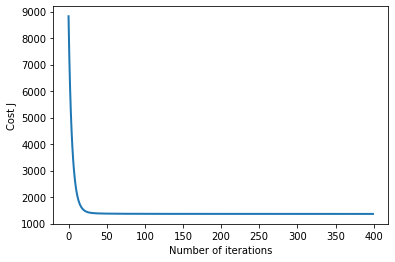

In [404]:
# Plot the convergence graph
plt.plot(np.arange(len(J_history)), J_history, lw=2)
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')

test the model

In [405]:
values = test_data.values
norm_values, mean, sigma = featureNormalize(values)

normalized_data = pd.DataFrame(norm_values, index=test_data.index, columns=test_data.columns)
normalized_data.head()

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,first_review.month,first_review.day-of-month,first_review.day-of-week
1,0.443719,0.644510,-0.242303,-0.242303,-3.328087,2.724427,-0.672305,-0.353468,-0.461333,-0.632643,...,0.691457,0.482145,0.436751,-0.484533,-0.081019,-0.234154,1.649715,0.029352,-0.236889,-1.140543
2,-1.538053,-0.101817,-0.242303,-0.242303,-3.257216,2.980950,-0.672305,-0.353468,-0.461333,-0.632643,...,-0.408617,0.482145,0.436751,-3.110883,-0.081019,-0.234154,-0.770499,0.682959,0.198105,1.422286
4,0.443719,-1.243259,-0.242303,-0.242303,-2.561255,2.396178,-1.344610,-0.353468,-0.461333,-0.632643,...,-0.408617,0.482145,0.436751,-1.797708,-0.081019,-0.234154,-0.653614,-1.604667,-1.433123,0.568009
6,-0.348990,0.644510,-0.242303,-0.242303,-2.580297,2.869592,1.344610,1.119387,1.863718,2.080173,...,0.691457,0.482145,0.436751,-0.484533,1.084704,-0.234154,-0.749872,1.009763,-1.106878,-0.286267
8,0.443719,-0.233522,-0.242303,-0.242303,-3.118621,2.792483,0.672305,-0.353468,0.701192,0.045561,...,0.691457,0.482145,0.436751,0.828641,1.084704,-0.234154,-0.412967,0.029352,1.285590,-1.140543


In [406]:
m = test_data.shape[0]
# Add intercept term to X
X = np.concatenate([np.ones((m, 1)), normalized_data], axis=1)

testing the model

In [407]:
predicted_price = np.dot(X, theta)

diff_from_truth = np.abs(y_test - predicted_price)
success_condition = 50 # dollar per night
success_rate = (np.sum(diff_from_truth < 50) * 100) / diff_from_truth.size
print('success rate for difference up to 50$ is: ', success_rate,'%')


success rate for difference up to 50$ is:  78.6564132327336 %


## classify cheap or expensive listing using logistic regression ML

 we chose dam square to be Amsterdam's center

In [408]:
city_center = Point(52.373204, 4.892694)

 cost function and optimization

In [409]:
def sigmoid(z):
    """
    Compute sigmoid function given the input z.

    Parameters
    ----------
    z : array_like
        The input to the sigmoid function. This can be a 1-D vector
        or a 2-D matrix.

    Returns
    -------
    g : array_like
        The computed sigmoid function. g has the same shape as z, since
        the sigmoid is computed element-wise on z.

    Instructions
    ------------
    Compute the sigmoid of each value of z (z can be a matrix, vector or scalar).
    """
    # convert input to a numpy array
    z = np.array(z)

    # You need to return the following variables correctly
    g = np.zeros(z.shape)

    mat1 = np.ones(z.shape)
    g = mat1/(mat1 + np.exp(-z))

    return g
def costFunction(theta, X, y):
    """
    Compute cost and gradient for logistic regression.

    Parameters
    ----------
    theta : array_like
        The parameters for logistic regression. This a vector
        of shape (n+1, ).

    X : array_like
        The input dataset of shape (m x n+1) where m is the total number
        of data points and n is the number of features. We assume the
        intercept has already been added to the input.

    y : arra_like
        Labels for the input. This is a vector of shape (m, ).

    Returns
    -------
    J : float
        The computed value for the cost function.

    grad : array_like
        A vector of shape (n+1, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.

    Instructions
    ------------
    Compute the cost of a particular choice of theta. You should set J to
    the cost. Compute the partial derivatives and set grad to the partial
    derivatives of the cost w.r.t. each parameter in theta.
    """
    # Initialize some useful values
    m = y.size  # number of training examples

    J = 0
    grad = np.zeros(theta.shape)

    J = (1/m) * (np.dot((-y).T,np.log(sigmoid(np.dot(X,theta)))) - np.dot((1-y).T,np.log(1-sigmoid(np.dot(X,theta)))))
    grad = (1/m) * np.dot(X.T,(sigmoid(np.dot(X,theta))-y))

    # =============================================================
    return J, grad

 measure distance from downtown

In [410]:
geometry = []
for index, row in cleaned_data.iterrows() :
    geometry.append(Point(row['latitude'], row['longitude']))

geo_data = gpd.GeoDataFrame(geometry)
geo_data.head()

,0
0,POINT (52.32336931905056 4.977729820098881)
1,POINT (52.31563541152141 4.978166362035691)
2,POINT (52.31671072387667 4.986617637373466)
3,POINT (52.32727036486493 4.967351995112772)
4,POINT (52.32698144329306 4.982948910311372)


 create cheap\expensive feature = y

 create data frame with only distance and room type features = X
 translate room type to 1/0

 visualize the data

 choosing train and test data

 normalize the data

 concatenate X

using the model

 predict and success rate